<a href="https://colab.research.google.com/github/charlesaraya/deep-learning-notebooks/blob/main/Forecasting/Weather_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Weather Forecasting

The challenge at hand, as with any forecasting task, requires capturing patterns in historical data to predict future events. The goal is to explore various models for temperature prediction, from simple statistical approaches and progressing to deep learning models, to assess how well different models perform on a weather dataset

### Setup

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import IPython.display

## Dataset
The Max Planck Institute for Biogeochemistry (Jena, Germany) has on its roof a weather station that's been measuring and recording weather data since 2003 up until today.

Its intruments track 11 variables, measuring air temperature, relative air humidity, air pressure, wind velocity, precipitation, etc. The sensors stream signals every 10 seconds, and their averages, totals, maxima, etc. are logged in 10-minute periods. The raw data is then downloaded and pre-processed to converted into its meaningful units. The cleaned dataset contains 21 features.

The dataset we'll work with was prepared by François Chollet, and contains data collected between 2009 and 2016.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    cache_dir = '/content/',
    extract = True
)
csv_path, _ = os.path.splitext(zip_path)
filename = 'jena_climate_2009_2016.csv'
csv_path = os.path.join(csv_path, filename)
df = pd.read_csv(csv_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Data Exploration

In [3]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


We quickly see **unexpected negative wind velocities** for `wv (m/s)` and  `max. wv (m/s)` (we'll take care of them later). Other than that, everything looks fine.



### Data Preprocessing

**We'll work with hourly predictions**. We will sub-sample the data from 10-minute intervals to one-hour intervals. We first date index the data.

In [8]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Date Time', inplace=True)
df.index.name = 'Date Time'

We could re-sample all 10-minute samples into their hour's average. In hindsight, this approach will mess up the dataset with NaN values if it finds missing timestamps. A lazy option would be sampling the 1st 10-minute reading of every hour (with `df[0::6]`).

Let's go with 1st approach :-)

In [9]:
# There are missing timestamps
df.loc[pd.to_datetime('2016-10-25 10:30:00'):pd.to_datetime('2016-10-28 12:50:00')]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2016-10-25 10:30:00,994.67,9.48,283.07,8.33,92.5,11.87,10.98,0.89,6.90,11.04,1220.83,1.53,2.24,144.1
2016-10-28 12:50:00,1003.87,12.44,285.28,7.96,74.1,14.46,10.71,3.74,6.66,10.67,1219.53,1.52,4.22,283.9


In [15]:
expected_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10min')
missing_timestamps = expected_index.difference(df.index)
print(f"Missing timestamps: {len(missing_timestamps)}")

Missing timestamps: 544


In [16]:
# And some are duplicated
print(df.index.value_counts().sort_values(ascending=False))
df.loc[pd.to_datetime('2014-03-21 12:50:00')]

Date Time
2014-03-20 11:20:00    2
2014-03-21 17:20:00    2
2014-03-21 17:10:00    2
2014-03-21 17:00:00    2
2014-03-21 16:50:00    2
                      ..
2016-12-29 18:30:00    1
2016-12-29 16:30:00    1
2016-12-29 16:40:00    1
2016-12-29 16:50:00    1
2016-12-29 06:20:00    1
Name: count, Length: 420224, dtype: int64


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2014-03-21 12:50:00,980.85,19.28,294.06,5.24,39.63,22.4,8.88,13.52,5.65,9.05,1164.41,12.16,18.09,213.6
2014-03-21 12:50:00,980.85,19.28,294.06,5.24,39.63,22.4,8.88,13.52,5.65,9.05,1164.41,12.16,18.09,213.6


In [17]:
# Find duplicates
duplicates = df.index[df.index.duplicated(keep=False)]
print(f"Number of duplicate timestamps: {duplicates.nunique()}")

Number of duplicate timestamps: 327


We first remove the duplicate timestamps.

In [18]:
# We keep the first
df = df[~df.index.duplicated(keep='first')]

Then we tackle missing timestamps.

In [20]:
# Adds the mnissing indixes, and fills them with NaN
df = df.reindex(expected_index)

In [22]:
# check which rows have NaN values
df[df.isna().any(axis=1)].head(2)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
2009-10-08 09:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-10-08 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sure theren is a better and smart way to fill out the missing data. we'll just move forward the previous available value forward.

In [24]:
# Fill Missing Values
df.ffill(inplace=True)  # Forward-fill

In [27]:
# check if there are NaN rows
missing_timestamps = expected_index.difference(df.index)
print(f"Missing timestamps: {len(missing_timestamps)}")

Missing timestamps: 0


We're all set for resampling into one-hour intervals!

In [28]:
df = df.resample('h').mean()

In [35]:
# Check there are no missing values after resampling
df[df.isna().any(axis=1)]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)


Before, we noticed **extreme values** for the average and max wind velocity values, of -9999.00. These are clearly incorrect calculations. We'll any negative value to 0.0.

In [37]:
criteria = df['wv (m/s)'] < 0
df.loc[criteria, 'wv (m/s)'] = 0.0

criteria = df['max. wv (m/s)'] < 0
df.loc[criteria, 'max. wv (m/s)'] = 0.0

print(f"min(wv (m/s)): {df['wv (m/s)'].min()}, min(max. wv (m/s)): {df['max. wv (m/s)'].min()}")

min(wv (m/s)): 0.0, min(max. wv (m/s)): 0.0


### Feature engineering

There are a few crucial feature transformations that can significantly improve model performance

#### Time-based Features

Weather patterns often change depending on the time of day or season.  For example, the same time of day on different dates is likely to have similar patterns, or the same months of the year across years will show seasonality.

Without transforming the time-based features, the model might interpret the difference as a large gap when, in fact, it's just a cyclical pattern, hence, encoding these as cyclical features can help capture these patterns.

- **Time of day** repeats every 24 hours, so 0:00 and 23:00 represent similar times in the cycle.
- **Day of Year**: Days repeat annually, so December and January are conceptually close.

To deal with periodicity, the most common technique, which applies sine and cosine transformations.

First, let's convert the string date time into manageable numerical seconds.

In [38]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

year = 365.2425 * day
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#### Cyclical Features

Wind direction is a cyclical feature, which means that 0° and 360° represent the same direction (North). Using it directly as a linear feature can lead to problems because the model might treat 360° as far from 0° when, in reality, they are the same. The best way to handle cyclical features like wind direction is to encode it using sine and cosine transformations to capture its periodic nature.

Interacting wind velocity with wind direction can help capture a meaningful relationships between them, one the model might not be able to learn on its own.

Now, let's transforming a few features to ensure they become meaningful for the models.

In [39]:
# Convert wind direction from degrees to radians.
wd_rad = df['wd (deg)'] * np.pi / 180

# Get the average and max wind velocity vector components.
df['wv x (m/s)'] = df['wv (m/s)'] * np.cos(wd_rad)
df['wv y (m/s)'] = df['wv (m/s)'] * np.sin(wd_rad)

df['max. wv x (m/s)'] = df['max. wv (m/s)'] * np.cos(wd_rad)
df['max. wv y (m/s)'] = df['max. wv (m/s)'] * np.sin(wd_rad)

# Let remove and replace features
df = df.drop(['wd (deg)', 'wv (m/s)', 'max. wv (m/s)'], axis=1)

#### Normalizization and Scaling

Standardization ensure features are on a similar scale, helping the model to learn, among other things, avoiding large deviations dominate the bias the distribution.

The mean and standard deviation should be computed using the training data, to avoid leaking information to the values in the validation and test sets. First we should split the data into training, validation and testing.

In [40]:
def split_data(df, train_ratio, val_ratio):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * val_ratio)
    df_train = df[:train_end]
    df_val = df[train_end:train_end+val_end]
    df_test = df[train_end+val_end:]

    return df_train, df_val, df_test

df_train, df_val, df_test = split_data(df, 0.7, 0.15)

In [42]:
print(f"Train shape: {df_train.shape}" \
      f"\nVal shape: {df_val.shape}" \
      f"\nTest shape: {df_test.shape}")

Train shape: (49090, 19)
Val shape: (10519, 19)
Test shape: (10520, 19)


In [41]:
mean_train = df_train.mean()
std_train = df_train.std()

df_train = (df_train - mean_train) / std_train
df_val = (df_val - mean_train) / std_train
df_test = (df_test - mean_train) / std_train

## Data Manaagement

Models can generate **sequence-to-one** predictions, and **sequence-to-sequence** predictions. Furthermore they can make **single-time-step** predictions (predict next day's weather) and **multi-time-step** predictions (predict this weekend's weather).

We can create a data manager class that helps generate a data window based on the predictive predictive capability we want for our model.


In [64]:
class DataManager():
    def __init__(
        self,
        x_size,
        y_size,
        window_offset,
        train_data,
        val_data,
        test_data,
        y_columns = None,
    ):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        # Work out the label column indices.
        self.y_columns = y_columns
        if y_columns is not None:
            self.y_columns_indices = {name: i for i, name in enumerate(y_columns)}
            self.column_indices = {name: i for i, name in enumerate(train_data.columns)}

        # Window params
        self.x_size = x_size
        self.y_size = y_size
        self.window_offset = window_offset
        self.window_size = x_size + self.window_offset

        # Sliding window indices
        self.x_slice = slice(0, self.x_size)
        self.x_indices = np.arange(self.window_size)[self.x_slice]

        self.y_start = self.window_size - self.y_size
        self.y_slice = slice(self.y_start, None)
        self.y_indices = np.arange(self.window_size)[self.y_slice]

    def __repr__(self) -> str:
        return f"Input: {self.x_indices}" \
                f"\nOutput: {self.y_indices}" \
                f"\nWindow Size: {self.window_size}"

## Split Window Data

We create a method that will split data according to the desired window.


In [65]:
def split_window(self, data):
    x_data = data[:, self.x_slice, :]
    y_data = data[:, self.y_slice, :]
    if self.y_columns is not None:
        y_data = tf.stack(
            [y_data[:, :, self.column_indices[name]] for name in self.y_columns],
            axis = -1
        )

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    x_data.set_shape([None, self.x_size, None])
    y_data.set_shape([None, self.y_size, None])

    return x_data, y_data

DataManager.split_window = split_window

## Plot data

In [83]:
def plot(self, x_data, y_data, predictions=None, col_name=None, col_index=None, y_index=None, x_indices=None, y_indices=None, max_subplots=3):

    plt.figure(figsize=(12, 8))

    max_n = min(max_subplots, len(x_data))
    col_name = col_name

    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{col_name} [normed]')
        plt.plot(x_indices, x_data[n, :, col_index], label='Inputs', marker='.', zorder=-10)

        plt.scatter(y_indices, y_data[n, :, y_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)

        if predictions is not None:
            plt.scatter(y_indices, predictions[n, :, 0], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

DataManager.plot = plot

## Test Data Manager

In this toy example, we create a window span of, 7 hours of input, and 3 hours of target output.

In [80]:
dm = DataManager(
    x_size = 7,
    y_size = 3,
    window_offset = 3,
    train_data = df_train,
    val_data = df_val,
    test_data = df_test,
    y_columns = ['T (degC)'],
)
dm

Input: [0 1 2 3 4 5 6]
Output: [7 8 9]
Window Size: 10

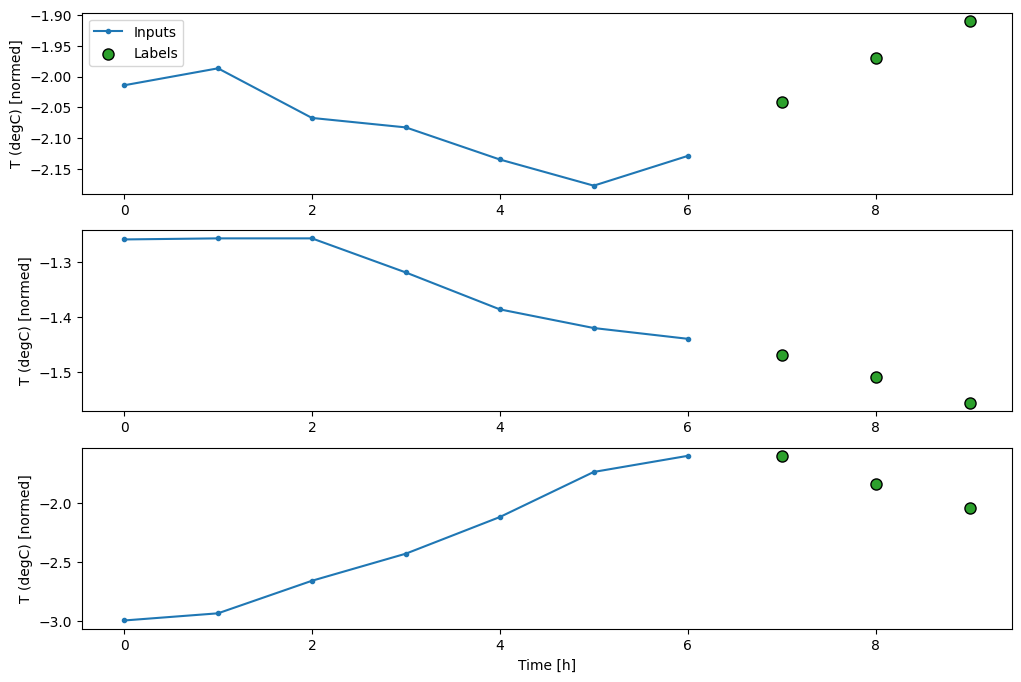

In [82]:
x_data, y_data = dm.split_window(
    tf.stack([
        df_train[:dm.window_size],
        df_train[100:100+dm.window_size],
        df_train[200:200+dm.window_size],
    ])
)

plot(x_data, y_data, col_name='T (degC)', col_index=1, y_index=0, x_indices=dm.x_indices, y_indices=dm.y_indices)

## Create Dataset

In [84]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data = data,
        targets = None,
        sequence_length = self.window_size,
        sequence_stride = 1,
        shuffle = True,
        batch_size = 32,
    )
    ds = ds.map(self.split_window)
    return ds

@property
def train(self):
    return self.make_dataset(self.train_data)

@property
def val(self):
    return self.make_dataset(self.val_data)

@property
def test(self):
    return self.make_dataset(self.test_data)

DataManager.make_dataset = make_dataset
DataManager.train = train
DataManager.val = val
DataManager.test = test

In [85]:
dm.train.element_spec

(TensorSpec(shape=(None, 7, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None))

In [87]:
for batch_idx, (x_batch, y_batch) in enumerate(dm.test.take(5)):
    print(f"[{batch_idx}]: Inputs: {x_batch.shape}, Output: {y_batch.shape}")

[0]: Inputs: (32, 7, 19), Output: (32, 3, 1)
[1]: Inputs: (32, 7, 19), Output: (32, 3, 1)
[2]: Inputs: (32, 7, 19), Output: (32, 3, 1)
[3]: Inputs: (32, 7, 19), Output: (32, 3, 1)
[4]: Inputs: (32, 7, 19), Output: (32, 3, 1)


## Single Step Model

The first model will predict the target value for a single time step into the future. In our case, since we're dealing with hourly data, it will predict the next hour's target weather variable (Temperature) for the next hour given current weather conditions.

In [88]:
single_step = DataManager(
    x_size = 1,
    y_size = 1,
    window_offset = 1,
    train_data = df_train,
    val_data = df_val,
    test_data = df_test,
    y_columns=['T (degC)'],
)

In [89]:
single_step_wider = DataManager(
    x_size = 24,
    y_size = 24,
    window_offset = 1,
    train_data = df_train,
    val_data = df_val,
    test_data = df_test,
    y_columns=['T (degC)'],
)

### Baseline model

To have a performance baseline as a point for comparison with other fancier models.

This first task is to predict temperature one hour into the future, given the current value of all features, including the current temperature.

A baseline model could be one that predicts no change, that is, the current temperature. It can be a good match-up against other models in a single-step predictive task given that weather conditions aren't generally changing too much from hour to hour.

In [90]:
class BaselineModel(tf.keras.Model):
    def __init__(self, y_index=None):
        super(BaselineModel, self).__init__()
        self.y_index = y_index

    def call(self, x_data):
        if self.y_index is None:
            return x_data

        result = x_data[:, :, self.y_index]
        return result[:, :, tf.newaxis]

In [91]:
baseline_model = BaselineModel(y_index=1)

baseline_model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

train_performance = {}
val_performance = {}
test_performance = {}

train_performance['Baseline'] = baseline_model.evaluate(single_step.train, return_dict=True)
val_performance['Baseline'] = baseline_model.evaluate(single_step.val, return_dict=True)
test_performance['Baseline'] = baseline_model.evaluate(single_step.test, return_dict=True)

1535/1535 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0124 - mean_absolute_error: 0.0789
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - mean_absolute_error: 0.0789
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - mean_absolute_error: 0.0757


In [92]:
train_performance['Baseline_wider_step'] = baseline_model.evaluate(single_step_wider.train, return_dict=True)
val_performance['Baseline_wider_step'] = baseline_model.evaluate(single_step_wider.val, return_dict=True)
test_performance['Baseline_wider_step'] = baseline_model.evaluate(single_step_wider.test, return_dict=True)

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0123 - mean_absolute_error: 0.0790
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - mean_absolute_error: 0.0789
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - mean_absolute_error: 0.0744


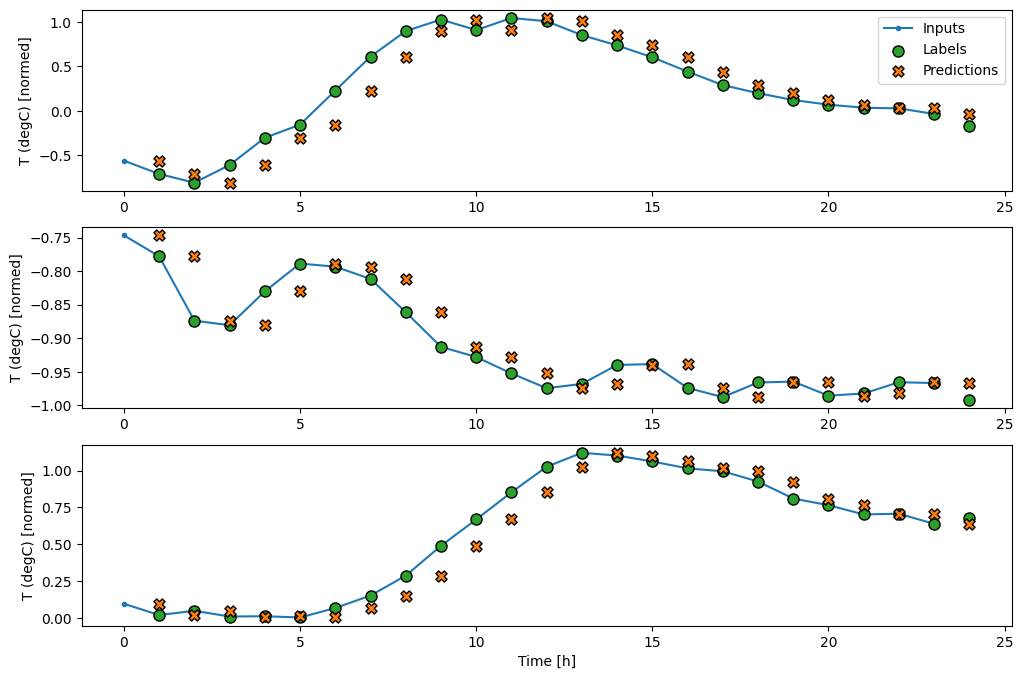

In [106]:
x_indices = single_step_wider.x_indices
y_indices = single_step_wider.y_indices
x_data, y_data = next(iter(single_step_wider.train))

# Predict and Plot
predictions = baseline_model(x_data)
dm.plot(
    x_data,
    y_data,
    predictions = predictions,
    col_name = 'T (degC)',
    col_index = 1,
    y_index = 0,
    x_indices = x_indices,
    y_indices = y_indices
)

### Linear model

The simplest trainable model you can apply to this task is to insert a linear transformation between the input and output. In this case the output from a time step only depends on that step. Such a model is a Dense layer with no activation function set.

In [110]:
EPOCHS = 20

linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
])
linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

history = linear_model.fit(
    single_step_wider.train,
    epochs = EPOCHS,
    validation_data = single_step_wider.val,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    ]
)

train_performance['Linear'] = linear_model.evaluate(single_step_wider.train, return_dict=True)
val_performance['Linear'] = linear_model.evaluate(single_step_wider.val, return_dict=True)
test_performance['Linear'] = linear_model.evaluate(single_step_wider.test, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.4806 - mean_absolute_error: 0.4674 - val_loss: 0.0163 - val_mean_absolute_error: 0.0951
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0141 - mean_absolute_error: 0.0881 - val_loss: 0.0084 - val_mean_absolute_error: 0.0677
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0667 - val_loss: 0.0078 - val_mean_absolute_error: 0.0657
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0076 - mean_absolute_error: 0.0647 - val_loss: 0.0076 - val_mean_absolute_error: 0.0651
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0076 - mean_absolute_error: 0.0644 - val_loss: 0.0076 - val_mean_absolute_error: 0.0645
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0641 - val_loss: 0.0075 - val_mean_absolute_error: 0.0644
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0075 - mean_absolute_e

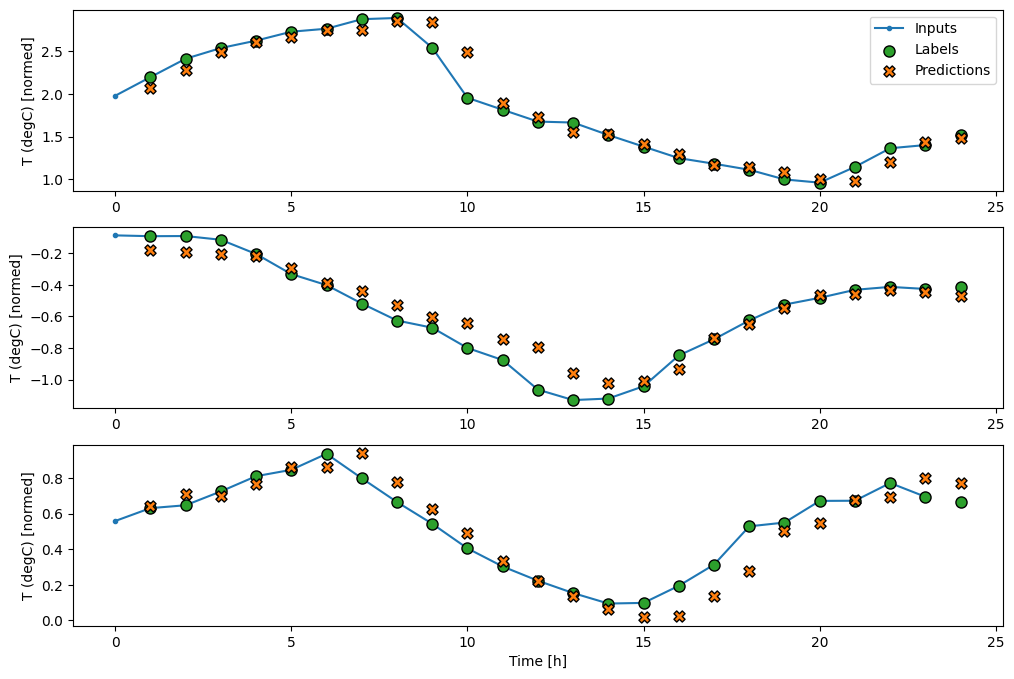

In [112]:
# Data it has not seen
x_test_data, y_test_data = next(iter(single_step_wider.test))

dm.plot(
    x_test_data,
    y_test_data,
    predictions = linear_model(x_test_data),
    col_name = 'T (degC)',
    col_index = 1,
    y_index = 0,
    x_indices = x_indices,
    y_indices = y_indices,
)

### MLP

In [114]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1),
])

mlp_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

history = mlp_model.fit(
    single_step_wider.train,
    epochs = EPOCHS,
    validation_data = single_step_wider.val,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    ]
)

train_performance['MLP'] = mlp_model.evaluate(single_step_wider.train, return_dict=True)
val_performance['MLP'] = mlp_model.evaluate(single_step_wider.val, return_dict=True)
test_performance['MLP'] = mlp_model.evaluate(single_step_wider.test, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0809 - mean_absolute_error: 0.1252 - val_loss: 0.0059 - val_mean_absolute_error: 0.0554
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0526 - val_loss: 0.0054 - val_mean_absolute_error: 0.0525
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0048 - mean_absolute_error: 0.0498 - val_loss: 0.0058 - val_mean_absolute_error: 0.0556
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0487 - val_loss: 0.0051 - val_mean_absolute_error: 0.0501
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0477 - val_loss: 0.0051 - val_mean_absolute_error: 0.0503
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0473 - val_loss: 0.0050 - val_mean_absolute_error: 0.0495
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0043 - mean_absolute_e

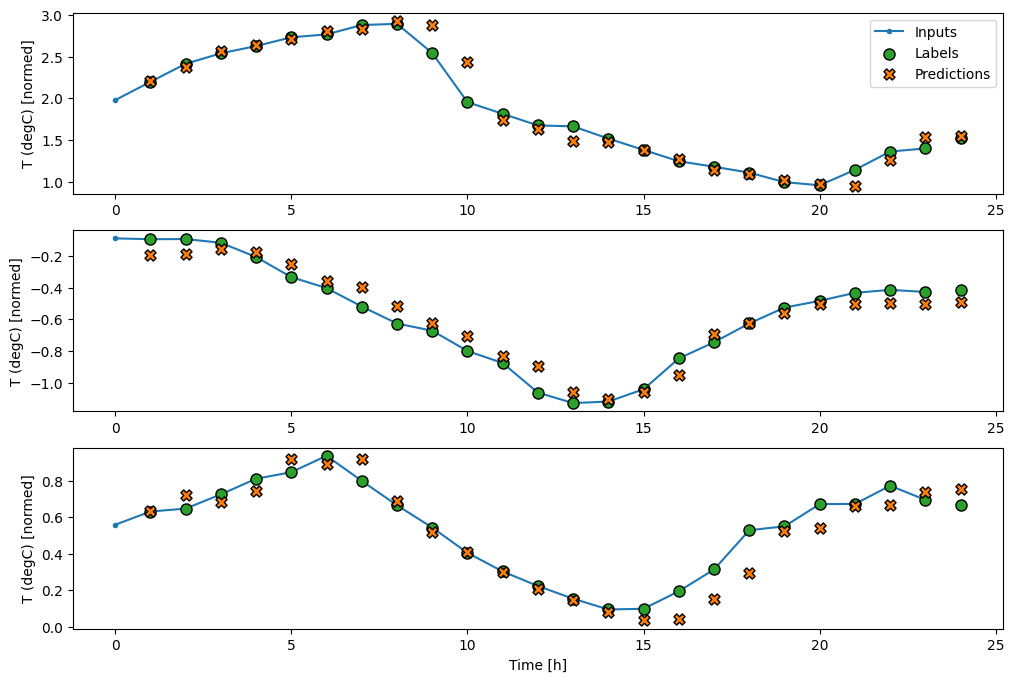

In [115]:
dm.plot(
    x_test_data,
    y_test_data,
    predictions = mlp_model(x_test_data),
    col_name = 'T (degC)',
    col_index = 1,
    y_index = 0,
    x_indices = x_indices,
    y_indices = y_indices,
)

### RNN

A single-time-step model has no context of its current input values. It doesn't have any information about how the features are changing over time

RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

In [116]:
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
])

LSTM_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

history = LSTM_model.fit(
    single_step_wider.train,
    epochs = EPOCHS,
    validation_data = single_step_wider.val,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    ]
)

train_performance['LSTM'] = LSTM_model.evaluate(single_step_wider.train, return_dict=True)
val_performance['LSTM'] = LSTM_model.evaluate(single_step_wider.val, return_dict=True)
test_performance['LSTM'] = LSTM_model.evaluate(single_step_wider.test, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0620 - mean_absolute_error: 0.1381 - val_loss: 0.0050 - val_mean_absolute_error: 0.0502
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0047 - mean_absolute_error: 0.0483 - val_loss: 0.0043 - val_mean_absolute_error: 0.0454
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0446 - val_loss: 0.0041 - val_mean_absolute_error: 0.0443
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0436 - val_loss: 0.0040 - val_mean_absolute_error: 0.0429
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0429 - val_loss: 0.0040 - val_mean_absolute_error: 0.0430
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0424 - val_loss: 0.0039 - val_mean_absolute_error: 0.0426
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0037 - mean_abso

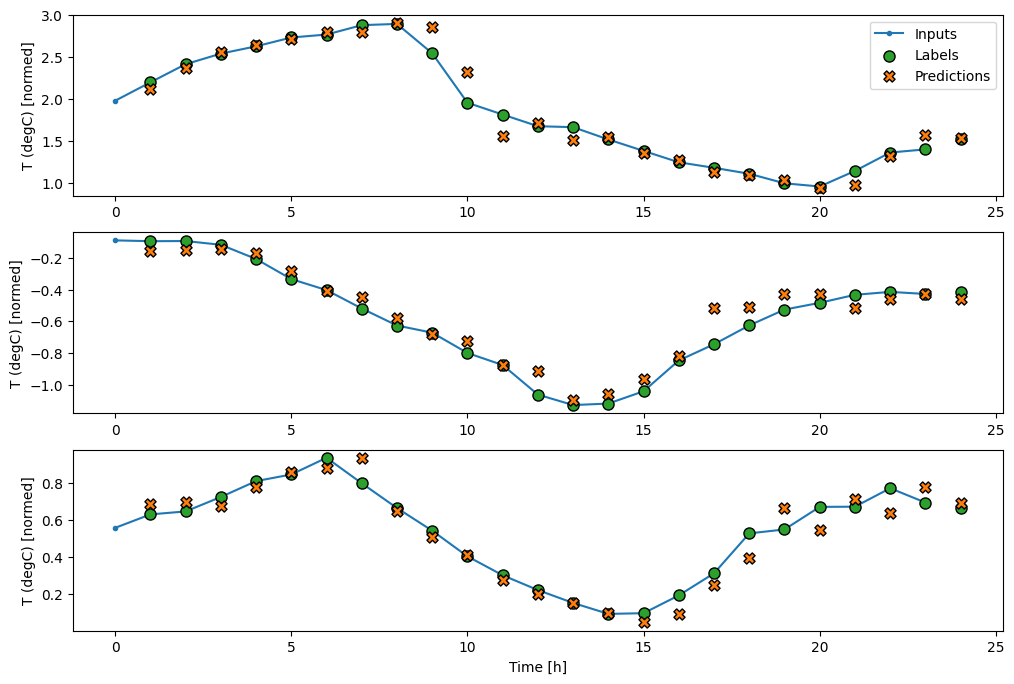

In [117]:
dm.plot(
    x_test_data,
    y_test_data,
    predictions = LSTM_model(x_test_data),
    col_name = 'T (degC)',
    col_index = 1,
    y_index = 0,
    x_indices = x_indices,
    y_indices = y_indices,
)

## Preformance

In [119]:
train_performance

{'Baseline': {'loss': 0.012348001822829247,
  'mean_absolute_error': 0.07891130447387695},
 'Baseline_wider_step': {'loss': 0.012344018556177616,
  'mean_absolute_error': 0.07890859991312027},
 'Linear': {'loss': 0.007497655693441629,
  'mean_absolute_error': 0.06431378424167633},
 'MLP': {'loss': 0.004249679856002331,
  'mean_absolute_error': 0.046594321727752686},
 'LSTM': {'loss': 0.0035976034123450518,
  'mean_absolute_error': 0.04184446856379509}}

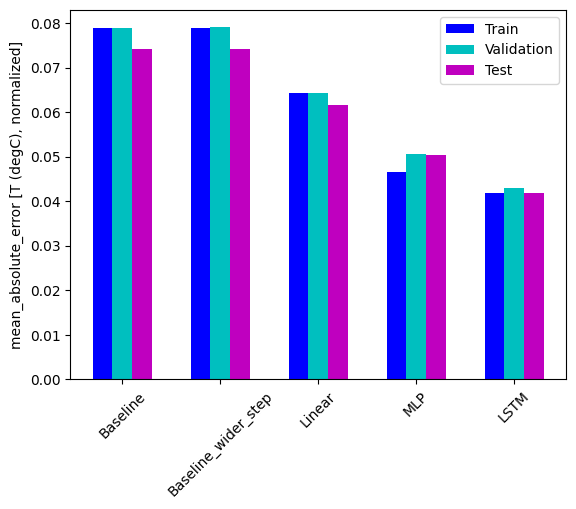

In [125]:
x = np.arange(len(test_performance))
width = 0.2
metric_name = 'mean_absolute_error'

train_mae = [v[metric_name] for v in train_performance.values()]
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in test_performance.values()]

plt.bar(x - 0.2, train_mae, width, label='Train', color='b')
plt.bar(x, val_mae, width, label='Validation', color='c')
plt.bar(x + 0.2, test_mae, width, label='Test', color='m')

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.xticks(ticks=x, labels=test_performance.keys(), rotation=45)
plt.legend()

## Multi-step Model
The models so far all predicted a single output feature for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the labels.

In [126]:
output_size = 24
num_features = len(df.columns)

multi_step_wide = DataManager(
    x_size = 24,
    y_size = output_size,
    window_offset = 24,
    train_data = df_train,
    val_data = df_val,
    test_data = df_test,
    y_columns=['T (degC)'],
)
multi_step_wide

Input: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Output: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Window Size: 48

In [127]:
x_indices = multi_step_wide.x_indices
y_indices = multi_step_wide.y_indices
x_test_data, y_test_data = next(iter(multi_step_wide.test))

### One-shot Linear Model

In [321]:
linear_multi = tf.keras.Sequential([
    # Shape [batch, 1, features] (the last time step)
    tf.keras.layers.Lambda(lambda x: x[:,-1,:]),
    # Shape [batch, 1, out_steps*features]
    tf.keras.layers.Dense(output_size),
])

linear_multi.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

epochs = 20
history = linear_multi.fit(
    multi_step_wide.train,
    epochs = epochs,
    validation_data = multi_step_wide.val,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    ]
)

val_performance_multi = {}
performance_multi = {}

val_performance_multi['Linear_Multi'] = linear_multi.evaluate(multi_step_wide.val, return_dict=True)
performance_multi['Linear_Multi'] = linear_multi.evaluate(multi_step_wide.test, return_dict=True)

Epoch 1/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.4874 - mean_absolute_error: 0.4843 - val_loss: 0.1089 - val_mean_absolute_error: 0.2509
Epoch 2/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1129 - mean_absolute_error: 0.2573 - val_loss: 0.1065 - val_mean_absolute_error: 0.2481
Epoch 3/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1097 - mean_absolute_error: 0.2537 - val_loss: 0.1061 - val_mean_absolute_error: 0.2477
Epoch 4/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1092 - mean_absolute_error: 0.2529 - val_loss: 0.1062 - val_mean_absolute_error: 0.2476
Epoch 5/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1092 - mean_absolute_error: 0.2528 - val_loss: 0.1062 - val_mean_absolute_error: 0.2478


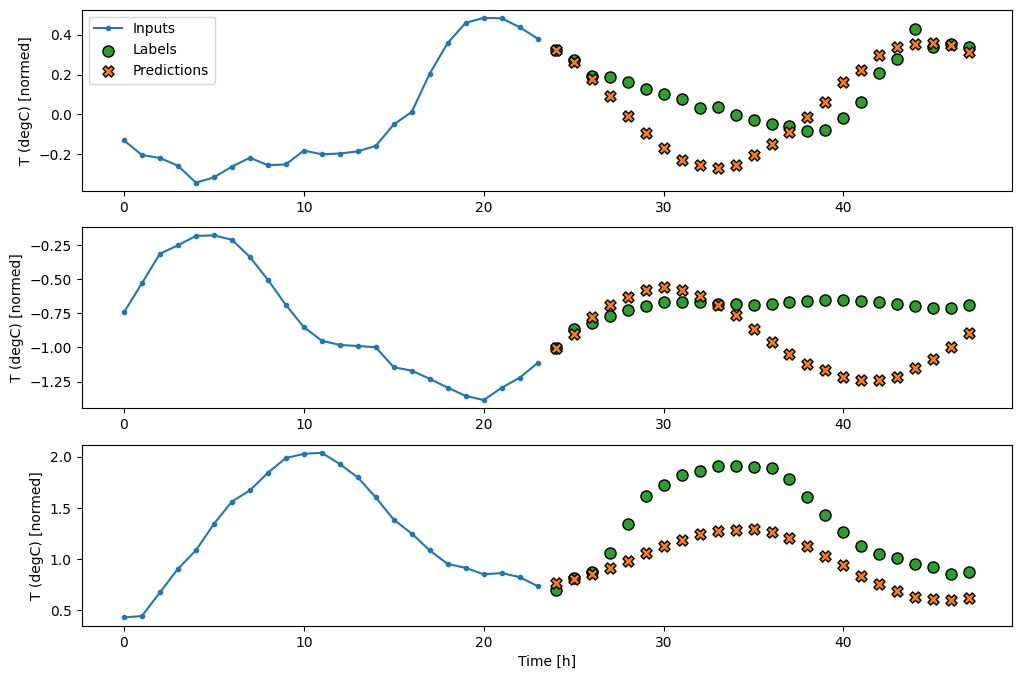

In [313]:
predictions = linear_multi(x_test_data)[:, :, tf.newaxis]

plot(
    x_test_data,
    y_test_data,
    predictions = predictions,
    col_name = 'T (degC)',
    col_index = 1,
    y_index = 0,
    x_indices = x_indices,
    y_indices = y_indices,
)

### MLP

In [320]:
mlp_multi = tf.keras.Sequential([
    # Shape [batch, 1, features] (the last time step)
    tf.keras.layers.Lambda(lambda x: x[:,-1,:]),
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape [batch, 1, out_steps]
    tf.keras.layers.Dense(output_size),
])

mlp_multi.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

epochs = 20
history = mlp_multi.fit(
    multi_step_wide.train,
    epochs = epochs,
    validation_data = multi_step_wide.val,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    ]
)
val_performance_multi['MLP_Multi'] = mlp_multi.evaluate(multi_step_wide.val, return_dict=True)
performance_multi['MLP_Multi'] = mlp_multi.evaluate(multi_step_wide.test, return_dict=True)

Epoch 1/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1195 - mean_absolute_error: 0.2508 - val_loss: 0.0823 - val_mean_absolute_error: 0.2157
Epoch 2/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0815 - mean_absolute_error: 0.2144 - val_loss: 0.0796 - val_mean_absolute_error: 0.2118
Epoch 3/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0780 - mean_absolute_error: 0.2090 - val_loss: 0.0787 - val_mean_absolute_error: 0.2098
Epoch 4/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0764 - mean_absolute_error: 0.2066 - val_loss: 0.0767 - val_mean_absolute_error: 0.2074
Epoch 5/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0752 - mean_absolute_error: 0.2047 - val_loss: 0.0771 - val_mean_absolute_error: 0.2080
Epoch 6/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0741 - mean_absolute_error: 0.2029 - val_loss: 0.0780 - val_mean_absolute_error: 0.2099


### RNN

In [326]:
lstm_multi = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(output_size)
])

lstm_multi.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

epochs = 20
history = lstm_multi.fit(
    multi_step_wide.train,
    epochs = epochs,
    validation_data = multi_step_wide.val,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    ]
)
val_performance_multi['LSTM_Multi'] = lstm_multi.evaluate(multi_step_wide.val, return_dict=True)
performance_multi['LSTM_Multi'] = lstm_multi.evaluate(multi_step_wide.test, return_dict=True)

Epoch 1/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 0.2008 - mean_absolute_error: 0.3147 - val_loss: 0.0771 - val_mean_absolute_error: 0.2104
Epoch 2/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.0747 - mean_absolute_error: 0.2073 - val_loss: 0.0737 - val_mean_absolute_error: 0.2041
Epoch 3/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0692 - mean_absolute_error: 0.1979 - val_loss: 0.0710 - val_mean_absolute_error: 0.1992
Epoch 4/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0663 - mean_absolute_error: 0.1927 - val_loss: 0.0710 - val_mean_absolute_error: 0.1987
Epoch 5/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.0640 - mean_absolute_error: 0.1890 - val_loss: 0.0725 - val_mean_absolute_error: 0.2009
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0728 - mean_absolute_error: 0.2006
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0662 - mean_absolute_error: 0.1952


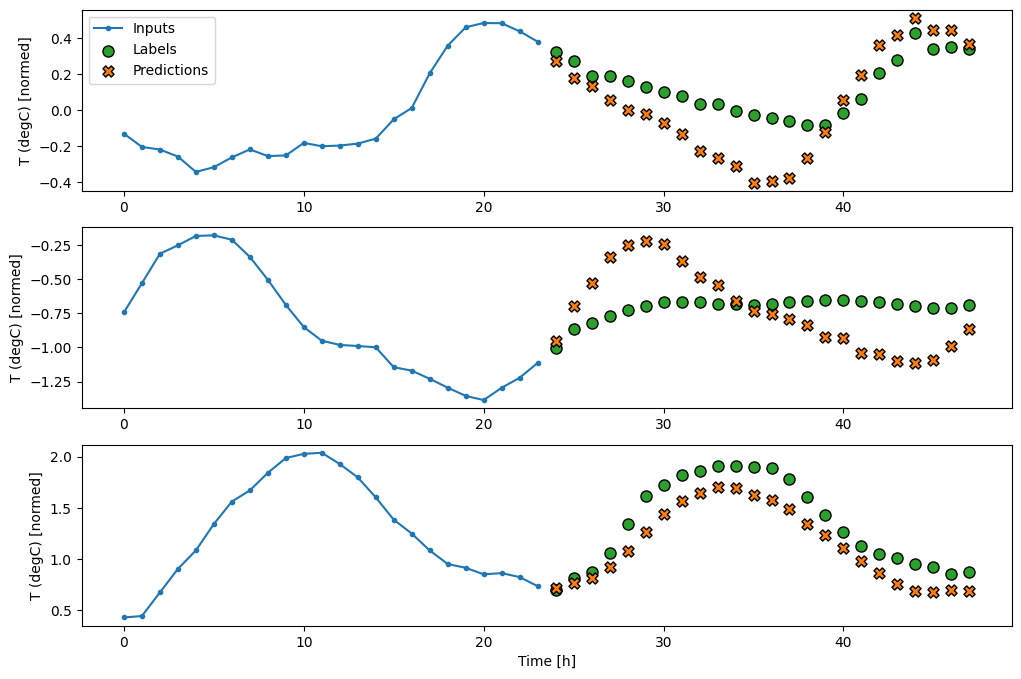

In [328]:
predictions = lstm_multi(x_test_data)[:, :, tf.newaxis]

plot(
    x_test_data,
    y_test_data,
    predictions = predictions,
    col_name = 'T (degC)',
    col_index = 1,
    y_index = 0,
    x_indices = x_indices,
    y_indices = y_indices,
)

### Autoregressive Model

A model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one. The model can be set up to produce output with a varying length. Even a trained single-step or multi-output model can be repurposed into an autoregressive feedback loop.

In [331]:
class FeedBackLSTM(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        """Initialize its internal state based on the inputs.
        Once trained, this state will capture the relevant parts of the input history.
        With the state initialized, and an initial prediction the model can continue
        feeding these predictions at each step back as the input.
        """
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state, training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

feedback_model = FeedBackLSTM(units=32, out_steps=output_size)


In [332]:
feedback_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

epochs = 20
history = feedback_model.fit(
    multi_step_wide.train,
    epochs = epochs,
    validation_data = multi_step_wide.val,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    ]
)
val_performance_multi['Feedback'] = feedback_model.evaluate(multi_step_wide.val, return_dict=True)
performance_multi['Feedback'] = feedback_model.evaluate(multi_step_wide.test, return_dict=True)

Epoch 1/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.2496 - mean_absolute_error: 0.3599 - val_loss: 0.0892 - val_mean_absolute_error: 0.2297
Epoch 2/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.0873 - mean_absolute_error: 0.2273 - val_loss: 0.0832 - val_mean_absolute_error: 0.2208
Epoch 3/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - loss: 0.0791 - mean_absolute_error: 0.2152 - val_loss: 0.0884 - val_mean_absolute_error: 0.2254
Epoch 4/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.0746 - mean_absolute_error: 0.2081 - val_loss: 0.0804 - val_mean_absolute_error: 0.2152
Epoch 5/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0718 - mean_absolute_error: 0.2035 - val_loss: 0.0842 - val_mean_absolute_error: 0.2190
Epoch 6/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 79s 25ms/step - loss: 0.0701 - mean_absolute_error: 0.2005 - val_loss: 0.0822 - val_mean_absolute_error: 0.2157
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0815 - mean_absolute_erro

In [335]:
predictions.shape

TensorShape([32, 24, 19])

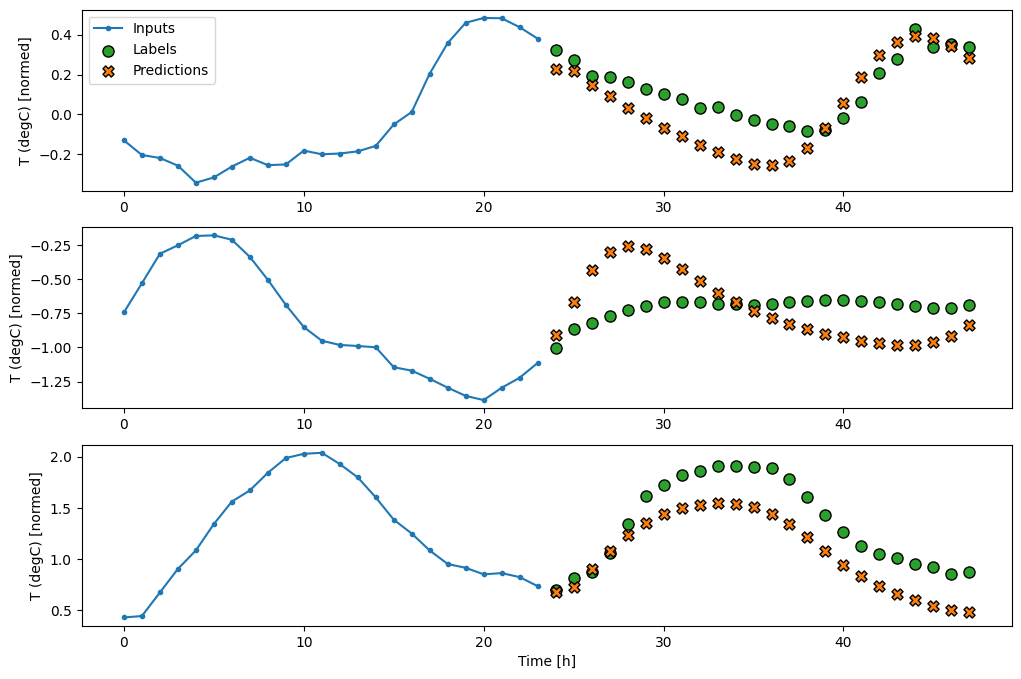

In [342]:
predictions = feedback_model(x_test_data)[:, :, tf.newaxis]

plot(
    x_test_data,
    y_test_data,
    predictions = predictions[:, :, -1, :],
    col_name = 'T (degC)',
    col_index = 1,
    y_index = 0,
    x_indices = x_indices,
    y_indices = y_indices,
)

In [347]:
predictions_multi

{'Linear': {'loss': 0.09950452297925949,
  'mean_absolute_error': 0.24088895320892334},
 'MLP': {'loss': 0.06604748964309692,
  'mean_absolute_error': 0.195145845413208},
 'Feedback': {'loss': 0.07533743977546692,
  'mean_absolute_error': 0.21102192997932434}}

In [350]:
for key in performance_multi:
    print(f"{key}")
    for metric in performance_multi[key]:
        print(f"  {metric}: {performance_multi[key][metric]:.4f}")

x = np.arange(len(performance_multi))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance_multi.values()]
test_mae = [v[metric_name] for v in performance_multi.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_multi.keys(),
           rotation=45)
_ = plt.legend()

NameError: name 'performance_multi' is not defined